In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
np.set_printoptions(suppress=True)

## Load all the Dataset Data

In [2]:
import os
import json

PRE_PROCESS_DATA_FOLDER = "pre_processed_data"

In [3]:
def infer_column_type(column:pd.Series):
    try:
        column = pd.to_numeric(column)
    except:
        print("Failed cast to a numeric type.")
    if column[0] == "False":
        
         False
    elif column[0] == "True":
        column = True
    column = column.astype(str)
    return column


In [4]:
data_list = []

for file in os.listdir(PRE_PROCESS_DATA_FOLDER):
    if ".json" not in file:
        continue
    with open(os.path.join(PRE_PROCESS_DATA_FOLDER, file), "r") as f:
        load_data = json.load(f)
    data_list.append(pd.Series(list(load_data.values()), index=load_data.keys()))

In [5]:
data = pd.DataFrame(data_list)

In [151]:
# Filters to apply:
approved_only = (data.approved_flag > 0).to_numpy() 
no_fixation_error = (data.fixation_error == False).to_numpy()
no_target_error = (data.target_error == False).to_numpy()
sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
acc_higher = (data.avg_roi_last_val > 20).to_numpy()
filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
filter_sets = np.array([True if set_lang in ["ES"] else False for set_lang in data["set_language"]])
# Set a maximum time to 60 minutes
# "EN", "DE", "ES", "TR"
max_time_min = 60
filter_max_time = (data.exp_total_time < max_time_min/0.000016666).to_numpy()

screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720

In [152]:
dict_filter = {
    #"filter_mturks" : filter_mturks,
    "filter_sets" : filter_sets,
    "Approved":approved_only,
    "Sample Rate": sample_higher_10,
    "Fix_Error, Target_Error": no_fixation_error & no_target_error,
    "screen_above_1280_720": screen_above_1280_720,
    "acc_thresh": acc_higher,
    f"Maximum time ({max_time_min} min)":filter_max_time
}

In [153]:
n_total = len(data)
current_filter = np.ones(len(data),dtype=bool)
for condition, f in dict_filter.items():
    n_data_filtered = len(data.iloc[~f & current_filter])
    per_cent = n_data_filtered/n_total * 100
    print(f"For condition ({condition}), {per_cent:.2f}% has been filtered. ({n_data_filtered} out of {n_total})")
    current_filter = current_filter & f
    n_total = len(data.iloc[current_filter])

For condition (filter_sets), 82.23% has been filtered. (495 out of 602)
For condition (Approved), 32.71% has been filtered. (35 out of 107)
For condition (Sample Rate), 12.50% has been filtered. (9 out of 72)
For condition (Fix_Error, Target_Error), 6.35% has been filtered. (4 out of 63)
For condition (screen_above_1280_720), 1.69% has been filtered. (1 out of 59)
For condition (acc_thresh), 29.31% has been filtered. (17 out of 58)
For condition (Maximum time (60 min)), 0.00% has been filtered. (0 out of 41)


In [154]:
# Combine filters into a mask
mask = np.ones(data.shape[0], dtype=bool)
for filter_name, filter_mask in dict_filter.items():
    mask = mask & filter_mask

In [155]:
data_filtered = data[mask].copy()
print("Before: ", data.shape, " After: ", data_filtered.shape)

Before:  (602, 153)  After:  (41, 153)


In [156]:
data_filtered[data_filtered.set_language=="EN"].worker_lang.value_counts()

Series([], Name: worker_lang, dtype: int64)

In [157]:
data_filtered[data_filtered.set_language=="DE"].worker_lang.value_counts()

Series([], Name: worker_lang, dtype: int64)

In [158]:
data_filtered[data_filtered.set_language=="ES"].worker_lang.value_counts()

Spanish               36
English                2
Chinese (Mandarin)     1
French                 1
Italian                1
Name: worker_lang, dtype: int64

In [159]:
# Load the text settings:
text_settings_all_settings = pd.read_csv("text_token_stats.csv", index_col=0)

In [160]:
text_settings_all_settings[text_settings_all_settings.trial_name == data_filtered["trial_0_name"][0]]

KeyError: 0

In [ ]:
data_filtered["question_0_name"]

0       meco_para_3_qa_0
2      meco_para_11_qa_1
5      meco_para_12_qa_0
9       meco_para_3_qa_1
11     meco_para_11_qa_1
             ...        
597    meco_para_11_qa_2
598     meco_para_3_qa_0
599     meco_para_3_qa_0
600    meco_para_11_qa_2
601     meco_para_3_qa_0
Name: question_0_name, Length: 152, dtype: object

In [ ]:
USE_TEXT_FEATURES = True
TASK_NAME = "nr"

In [161]:
# Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
data_for_cls_nr = []
data_for_cls_is = []
rows_dropped = 0
for i in range(10):
    for row_i, row in data_filtered.iterrows():
        # Remove rows where there is no fixation on text
        if row[f"trial_{i}_fixation_text_TRT"] == 0:
            assert row[f"trial_{i}_fixation_target_TRT"] == 0
            rows_dropped += 1
            continue
        set_lang = row["set_language"] 
        set_name = row["set_name"]
        worker_id = row["worker_id"]
        trial_name = row[f"trial_{i}_name"]
        target = row[f"question_{i}_name"]
        
        text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                        & (text_settings_all_settings["trial_name"] == trial_name)]
        word_sent_avg = text_features_row["sentence_count"].item()
        participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
        in_span_TRT = []
        out_span_TRT = []
        for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
            if type(fix_row["Span_word_is_in"]) is str:
                if target in fix_row["Span_word_is_in"]:
                    in_span_TRT.append(fix_row["TRT"])
            else:
                out_span_TRT.append(fix_row["TRT"])
        in_span_mean = np.nanmean(np.array(in_span_TRT))
        if np.isnan(in_span_mean):
            in_span_mean = 0
        out_span_mean = np.nanmean(np.array(out_span_TRT))
        if np.isnan(out_span_mean):
            out_span_mean = 0
        data_to_append = row[[
                f"trial_{i}_fixation_text_TRT", 
                f"trial_{i}_fixation_target_TRT", 
                f"trial_{i}_fixation_on_target", 
                f"question_{i}_target_to_fixation_ratio",
                f"trial_{i}_fixation_total",
                #f"trial_{i}_time",
                f"question_{i}_correct_flag"]].to_numpy()
        relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
        if USE_TEXT_FEATURES:
            data_to_append = np.hstack(( [
                                    in_span_mean,
                                    out_span_mean,
                                    relative_TRT,
                                    text_features_row["token_count"].item(),
                                    text_features_row["token_avg_length"].item(), 
                                      ], 
                                    data_to_append))
        else:
            data_to_append = np.hstack(( [
                                        in_span_mean,
                                        out_span_mean,
                                        relative_TRT,
                                        ], 
                                        data_to_append))
        # Trials < 5 are Normal Reading
        if i < 5:
            data_for_cls_nr.append(data_to_append)
        # Trials >= 5 are Information Seaking
        else:
            data_for_cls_is.append(data_to_append)
data_for_cls_nr = np.array(data_for_cls_nr)
data_for_cls_is = np.array(data_for_cls_is)

C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))


C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\1663479321.py:30: Ru

In [162]:
rows_dropped, len(data_for_cls_is), len(data_for_cls_nr), len(data_for_cls_is)+len(data_for_cls_nr)

(1, 204, 205, 409)

In [163]:
18/1940

0.009278350515463918

In [164]:
data_for_cls_is[:2]

array([[0.0, 262.3636363636364, 0.2048106006049258, 6943.0, 1422.0, 14,
        0.2121212121, 66, 1],
       [0.0, 221.625, 0.03925790955772735, 6037.0, 237.0, 3,
        0.0384615385, 78, 1]], dtype=object)

In [165]:
if TASK_NAME == "nr":
    data_for_classifier = np.array(data_for_cls_nr,dtype=float)
else:
    data_for_classifier = np.array(data_for_cls_is,dtype=float)

In [166]:
all_data = np.vstack((data_for_cls_is,data_for_cls_nr))

In [167]:
print("Information Seeking")
len(data_for_cls_is[data_for_cls_is[:,-1] == 1]), len(data_for_cls_is[data_for_cls_is[:,-1] == 0])

Information Seeking


(170, 34)

In [168]:
data_for_cls_is[data_for_cls_is[:,-1] == 1][:,-2].mean()

135.74705882352941

In [169]:
data_for_cls_is[data_for_cls_is[:,-1] == 0][:,-2].mean()

214.7941176470588

In [170]:
print("Normal Reading")
len(data_for_cls_nr[data_for_cls_nr[:,-1] == 1]), len(data_for_cls_nr[data_for_cls_nr[:,-1] == 0])

Normal Reading


(117, 88)

In [171]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 1][:,-2].mean()

244.008547008547

In [172]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 0][:,-2].mean()

225.17045454545453

In [173]:
data_for_classifier

array([[192.4       , 249.35483871,   0.03981623, ...,   0.04524887,
        221.        ,   1.        ],
       [329.94444444, 388.43333333,   0.17607091, ...,   0.15258216,
        426.        ,   1.        ],
       [  0.        ,  88.8       ,   0.        , ...,   0.        ,
          9.        ,   1.        ],
       ...,
       [ 70.        , 274.125     ,   0.00434082, ...,   0.00512821,
        195.        ,   1.        ],
       [278.66666667, 206.10344828,   0.04923685, ...,   0.03902439,
        205.        ,   1.        ],
       [  0.        , 169.95652174,   0.        , ...,   0.        ,
         65.        ,   0.        ]])

In [174]:
data_for_classifier[0]

array([  192.4       ,   249.35483871,     0.03981623, 24161.        ,
         962.        ,    10.        ,     0.04524887,   221.        ,
           1.        ])

In [175]:
data_for_classifier[:,:-1]

array([[192.4       , 249.35483871,   0.03981623, ...,  10.        ,
          0.04524887, 221.        ],
       [329.94444444, 388.43333333,   0.17607091, ...,  65.        ,
          0.15258216, 426.        ],
       [  0.        ,  88.8       ,   0.        , ...,   0.        ,
          0.        ,   9.        ],
       ...,
       [ 70.        , 274.125     ,   0.00434082, ...,   1.        ,
          0.00512821, 195.        ],
       [278.66666667, 206.10344828,   0.04923685, ...,   8.        ,
          0.03902439, 205.        ],
       [  0.        , 169.95652174,   0.        , ...,   0.        ,
          0.        ,  65.        ]])

In [176]:
X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]

In [177]:
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, y, test_size=0.2)

In [178]:
def upscale_dataset(X_train, y_train):
    minority_label = y_train[0]
    count_min_label = (y_train == minority_label).sum()
    for label in np.unique(y_train):
        n_examples = (y_train == label).sum()
        if n_examples < count_min_label:
            minority_label = label

    unbalance_n = (y_train!=minority_label).sum()-(y_train==minority_label).sum()
    indexes_to_add = np.random.choice(X_train[y_train==minority_label].shape[0], size=unbalance_n, replace=True)
    new_X_train = np.vstack((X_train, X_train[indexes_to_add,:]))
    new_y_train = np.hstack((y_train,np.zeros(unbalance_n)))
    balanced_dataset = np.hstack([new_X_train,new_y_train.reshape(-1,1)])
    np.random.shuffle(balanced_dataset)

    return balanced_dataset[:,:-1], balanced_dataset[:,-1]

In [179]:
#from imblearn.over_sampling import SMOTE

In [180]:
#sm = SMOTE()

In [181]:
X_train, y_train = upscale_dataset(X_train_unb, y_train_unb)

In [182]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = make_pipeline(StandardScaler(), LogisticRegression())
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.59459459, 0.43243243, 0.41666667, 0.52777778, 0.47222222])

In [183]:
scores.mean()

0.48873873873873885

In [184]:
clf.fit(X_train, y_train)
print("Acc Score: ", accuracy_score(y_test_unb, clf.predict(X_test_unb)), 
                    "F1-Score", f1_score(y_test_unb, clf.predict(X_test_unb), average="weighted"))

Acc Score:  0.5121951219512195 F1-Score 0.5191971058466566


In [185]:
(y_test_unb==0).sum()

15

In [186]:
confusion_matrix(y_test_unb, clf.predict(X_test_unb))

array([[ 9,  6],
       [14, 12]], dtype=int64)

In [187]:
baseline = DummyClassifier()
baseline.fit(X_train_unb,y_train_unb)

DummyClassifier()

In [188]:
print("Acc Score: ", accuracy_score(y_test_unb, baseline.predict(X_test_unb)),
             "F1-Score", f1_score(y_test_unb, baseline.predict(X_test_unb)))

Acc Score:  0.6341463414634146 F1-Score 0.7761194029850745


In [189]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

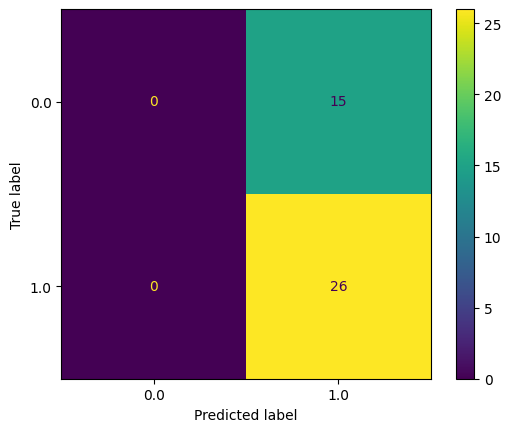

In [190]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb,baseline.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

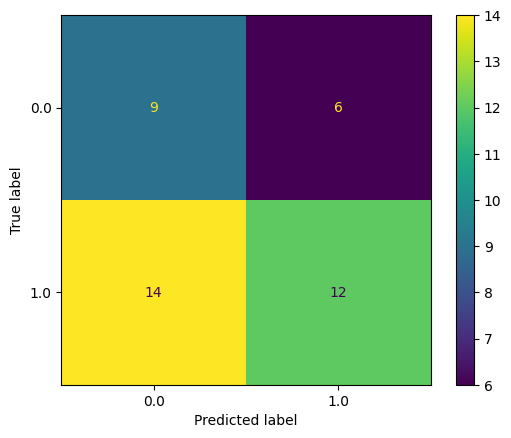

In [191]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb, clf.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

In [192]:
from sklearn.metrics import classification_report

In [193]:
print(classification_report(y_test_unb, clf.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.39      0.60      0.47        15
         1.0       0.67      0.46      0.55        26

    accuracy                           0.51        41
   macro avg       0.53      0.53      0.51        41
weighted avg       0.57      0.51      0.52        41



In [194]:
print(classification_report(y_test_unb, baseline.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.63      1.00      0.78        26

    accuracy                           0.63        41
   macro avg       0.32      0.50      0.39        41
weighted avg       0.40      0.63      0.49        41



c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [195]:
classifier_dict = {
    "Baseline (Chance)": DummyClassifier(strategy="uniform"),
    "Majority": DummyClassifier(strategy="prior"),
    "SVM": make_pipeline(StandardScaler(), SVC(gamma='auto')),
    "Log.Reg": make_pipeline(StandardScaler(), LogisticRegression()),
    "Random Forest": RandomForestClassifier(),
    #"MLPClassifier": MLPClassifier(),
}

In [196]:
classifier_results = {
    "Baseline (Chance)": [],
    "Majority": [],
    "SVM": [],
    "Log.Reg": [],
    "Random Forest": [],
    #"MLPClassifier": [],

}

In [197]:
runs = 10

In [206]:
for i in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
    for clf_name, clf in classifier_dict.items():
        if clf_name == "Majority":
            # Fit data to the original train data
            clf.fit(X_train, y_train)
        else:
            clf.fit(X_train_reb, y_train_reb)
        #print(f"## Results Clf: {clf_name}, seed = {i}")
        preds = clf.predict(X_test)
        acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
        f1_sco = f1_score(y_test, preds, average="weighted")
        f1_sco_macro = f1_score(y_test, preds, average="macro")
        #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
        classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))

In [207]:
print("Results for task: ", TASK_NAME.upper())
print("Is using text features: ", USE_TEXT_FEATURES)
results_df = pd.DataFrame()
for clf_name, results in classifier_results.items():
    results_row = pd.Series()
    print(f"## Results for {clf_name} ##")
    results = np.array(results)
    print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
    print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
    print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
    print()
    results_row[f"Acc (mean $n={runs}$)"] = results[:,0].mean()
    results_row[f"Acc (std $n={runs}$)"] = results[:,0].std()
    results_row[f"F1-Score Weighted (mean n={runs})"] = results[:,1].mean()
    results_row[f"F1-Score Weighted (std n={runs})"] = results[:,1].std()
    results_df[clf_name] = results_row

Results for task:  NR
Is using text features:  True
## Results for Baseline (Chance) ##
Acc: 0.4927 +/- 0.0738
F1-Score (Weighted): 0.4945 +/- 0.0716
F1-Score (Macro): 0.4778 +/- 0.0823

## Results for Majority ##
Acc: 0.5854 +/- 0.0488
F1-Score (Weighted): 0.4334 +/- 0.0597
F1-Score (Macro): 0.3686 +/- 0.0190

## Results for SVM ##
Acc: 0.6098 +/- 0.0862
F1-Score (Weighted): 0.6051 +/- 0.0868
F1-Score (Macro): 0.5921 +/- 0.0840

## Results for Log.Reg ##
Acc: 0.5768 +/- 0.0579
F1-Score (Weighted): 0.5723 +/- 0.0596
F1-Score (Macro): 0.5613 +/- 0.0560

## Results for Random Forest ##
Acc: 0.5732 +/- 0.0959
F1-Score (Weighted): 0.5715 +/- 0.0931
F1-Score (Macro): 0.5556 +/- 0.0948



C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  re

In [208]:
results_df.T

,Acc (mean $n=10$),Acc (std $n=10$),F1-Score Weighted (mean n=10),F1-Score Weighted (std n=10)
Baseline (Chance),0.492683,0.073818,0.494503,0.071618
Majority,0.585366,0.048780,0.433437,0.059653
SVM,0.609756,0.086233,0.605106,0.086835
Log.Reg,0.576829,0.057859,0.572251,0.059650
Random Forest,0.573171,0.095869,0.571541,0.093122


In [229]:
# Filters to apply:
approved_only = (data.approved_flag > 0).to_numpy() 
no_fixation_error = (data.fixation_error == False).to_numpy()
no_target_error = (data.target_error == False).to_numpy()
sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
acc_higher = (data.avg_roi_last_val > 0).to_numpy()
filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
filter_sets = np.array([True if set_lang in ["TR"] else False for set_lang in data["set_language"]])
# Set a maximum time to 60 minutes
# "EN", "DE", "ES", "TR"
max_time_min = 60
filter_max_time = (data.exp_total_time < max_time_min/0.000016666).to_numpy()

screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720
dict_filter = {
    #"filter_mturks" : filter_mturks,
    "filter_sets" : filter_sets,
    "Approved":approved_only,
    "Sample Rate": sample_higher_10,
    "Fix_Error, Target_Error": no_fixation_error & no_target_error,
    "screen_above_1280_720": screen_above_1280_720,
    "acc_thresh": acc_higher,
    f"Maximum time ({max_time_min} min)":filter_max_time
}
n_total = len(data)
current_filter = np.ones(len(data),dtype=bool)
for condition, f in dict_filter.items():
    n_data_filtered = len(data.iloc[~f & current_filter])
    per_cent = n_data_filtered/n_total * 100
    print(f"For condition ({condition}), {per_cent:.2f}% has been filtered. ({n_data_filtered} out of {n_total})")
    current_filter = current_filter & f
    n_total = len(data.iloc[current_filter])
# Combine filters into a mask
mask = np.ones(data.shape[0], dtype=bool)
for filter_name, filter_mask in dict_filter.items():
    mask = mask & filter_mask
data_filtered = data[mask].copy()
print("Before: ", data.shape, " After: ", data_filtered.shape)

USE_TEXT_FEATURES = False
TASK_NAME = "nr"

# Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
data_for_cls_nr = []
data_for_cls_is = []
rows_dropped = 0
for i in range(10):
    for row_i, row in data_filtered.iterrows():
        # Remove rows where there is no fixation on text
        if row[f"trial_{i}_fixation_text_TRT"] == 0:
            assert row[f"trial_{i}_fixation_target_TRT"] == 0
            rows_dropped += 1
            continue
        set_lang = row["set_language"] 
        set_name = row["set_name"]
        worker_id = row["worker_id"]
        trial_name = row[f"trial_{i}_name"]
        target = row[f"question_{i}_name"]
        
        text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                        & (text_settings_all_settings["trial_name"] == trial_name)]
        word_sent_avg = text_features_row["sentence_count"].item()
        participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
        in_span_TRT = []
        out_span_TRT = []
        for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
            if type(fix_row["Span_word_is_in"]) is str:
                if target in fix_row["Span_word_is_in"]:
                    in_span_TRT.append(fix_row["TRT"])
            else:
                out_span_TRT.append(fix_row["TRT"])
        in_span_mean = np.nanmean(np.array(in_span_TRT))
        if np.isnan(in_span_mean):
            in_span_mean = 0
        out_span_mean = np.nanmean(np.array(out_span_TRT))
        if np.isnan(out_span_mean):
            out_span_mean = 0
        data_to_append = row[[
                f"trial_{i}_fixation_text_TRT", 
                f"trial_{i}_fixation_target_TRT", 
                f"trial_{i}_fixation_on_target", 
                f"question_{i}_target_to_fixation_ratio",
                f"trial_{i}_fixation_total",
                #f"trial_{i}_time",
                f"question_{i}_correct_flag"]].to_numpy()
        relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
        if USE_TEXT_FEATURES:
            data_to_append = np.hstack(( [
                                    in_span_mean,
                                    out_span_mean,
                                    relative_TRT,
                                    text_features_row["token_count"].item(),
                                    text_features_row["token_avg_length"].item(), 
                                      ], 
                                    data_to_append))
        else:
            data_to_append = np.hstack(( [
                                        in_span_mean,
                                        out_span_mean,
                                        relative_TRT,
                                        ], 
                                        data_to_append))
        # Trials < 5 are Normal Reading
        if i < 5:
            data_for_cls_nr.append(data_to_append)
        # Trials >= 5 are Information Seaking
        else:
            data_for_cls_is.append(data_to_append)

data_for_cls_nr = np.array(data_for_cls_nr)
data_for_cls_is = np.array(data_for_cls_is)

if TASK_NAME == "nr":
    data_for_classifier = np.array(data_for_cls_nr,dtype=float)
else:
    data_for_classifier = np.array(data_for_cls_is,dtype=float)

X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, y, test_size=0.2)

#from imblearn.over_sampling import SMOTE
#sm = SMOTE()
X_train, y_train = upscale_dataset(X_train_unb, y_train_unb)

runs = 10
for i in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
    for clf_name, clf in classifier_dict.items():
        if clf_name == "Majority":
            # Fit data to the original train data
            clf.fit(X_train, y_train)
        else:
            clf.fit(X_train_reb, y_train_reb)
        #print(f"## Results Clf: {clf_name}, seed = {i}")
        preds = clf.predict(X_test)
        acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
        f1_sco = f1_score(y_test, preds, average="weighted")
        f1_sco_macro = f1_score(y_test, preds, average="macro")
        #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
        classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))

print("Results for task: ", TASK_NAME.upper())
print("Is using text features: ", USE_TEXT_FEATURES)
results_df = pd.DataFrame()
for clf_name, results in classifier_results.items():
    results_row = pd.Series()
    print(f"## Results for {clf_name} ##")
    results = np.array(results)
    print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
    print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
    print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
    print()
    results_row[f"Acc (mean $n={runs}$)"] = results[:,0].mean()
    results_row[f"Acc (std $n={runs}$)"] = results[:,0].std()
    results_row[f"F1-Score Weighted (mean n={runs})"] = results[:,1].mean()
    results_row[f"F1-Score Weighted (std n={runs})"] = results[:,1].std()
    results_df[clf_name] = results_row
print(y_train.shape, y_train_reb.shape, y_test.shape)
results_df.T

For condition (filter_sets), 62.62% has been filtered. (377 out of 602)
For condition (Approved), 32.00% has been filtered. (72 out of 225)
For condition (Sample Rate), 14.38% has been filtered. (22 out of 153)
For condition (Fix_Error, Target_Error), 4.58% has been filtered. (6 out of 131)
For condition (screen_above_1280_720), 0.00% has been filtered. (0 out of 125)
For condition (acc_thresh), 0.80% has been filtered. (1 out of 125)
For condition (Maximum time (60 min)), 2.42% has been filtered. (3 out of 124)
Before:  (602, 153)  After:  (121, 153)


C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:74: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:74: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:77: RuntimeWarning: Mean of empty slice
  out_span_mean = np.nanmean(np.array(out_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:74: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:74: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:74: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_14684\2604707395.py:77: 